In [2]:
# Libraries
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
from pytorchtools import EarlyStopping
from PIL import ImageFile

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing and Separation Data

In [3]:
batch_size = 64
classes = ["NORMAL", "PNEUMANIA"]
ImageFile.LOAD_TRUNCATED_IMAGES = True

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data_dir = '/content/drive/MyDrive/chest_xray/train'
test_data_dir = '/content/drive/MyDrive/chest_xray/test'

train_dataset = ImageFolder(root=train_data_dir, transform=transform)
test_dataset = ImageFolder(root=test_data_dir, transform=transform)

split = (0.8, 0.2)
train_size = int(split[0] * len(train_dataset))
valid_size = int(split[1] * len(train_dataset))

train_dataset, valid_dataset = random_split(train_dataset, (train_size, valid_size))
test_dataset, _ = random_split(test_dataset, (int(len(test_dataset)), 0))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Show random fish images from train data

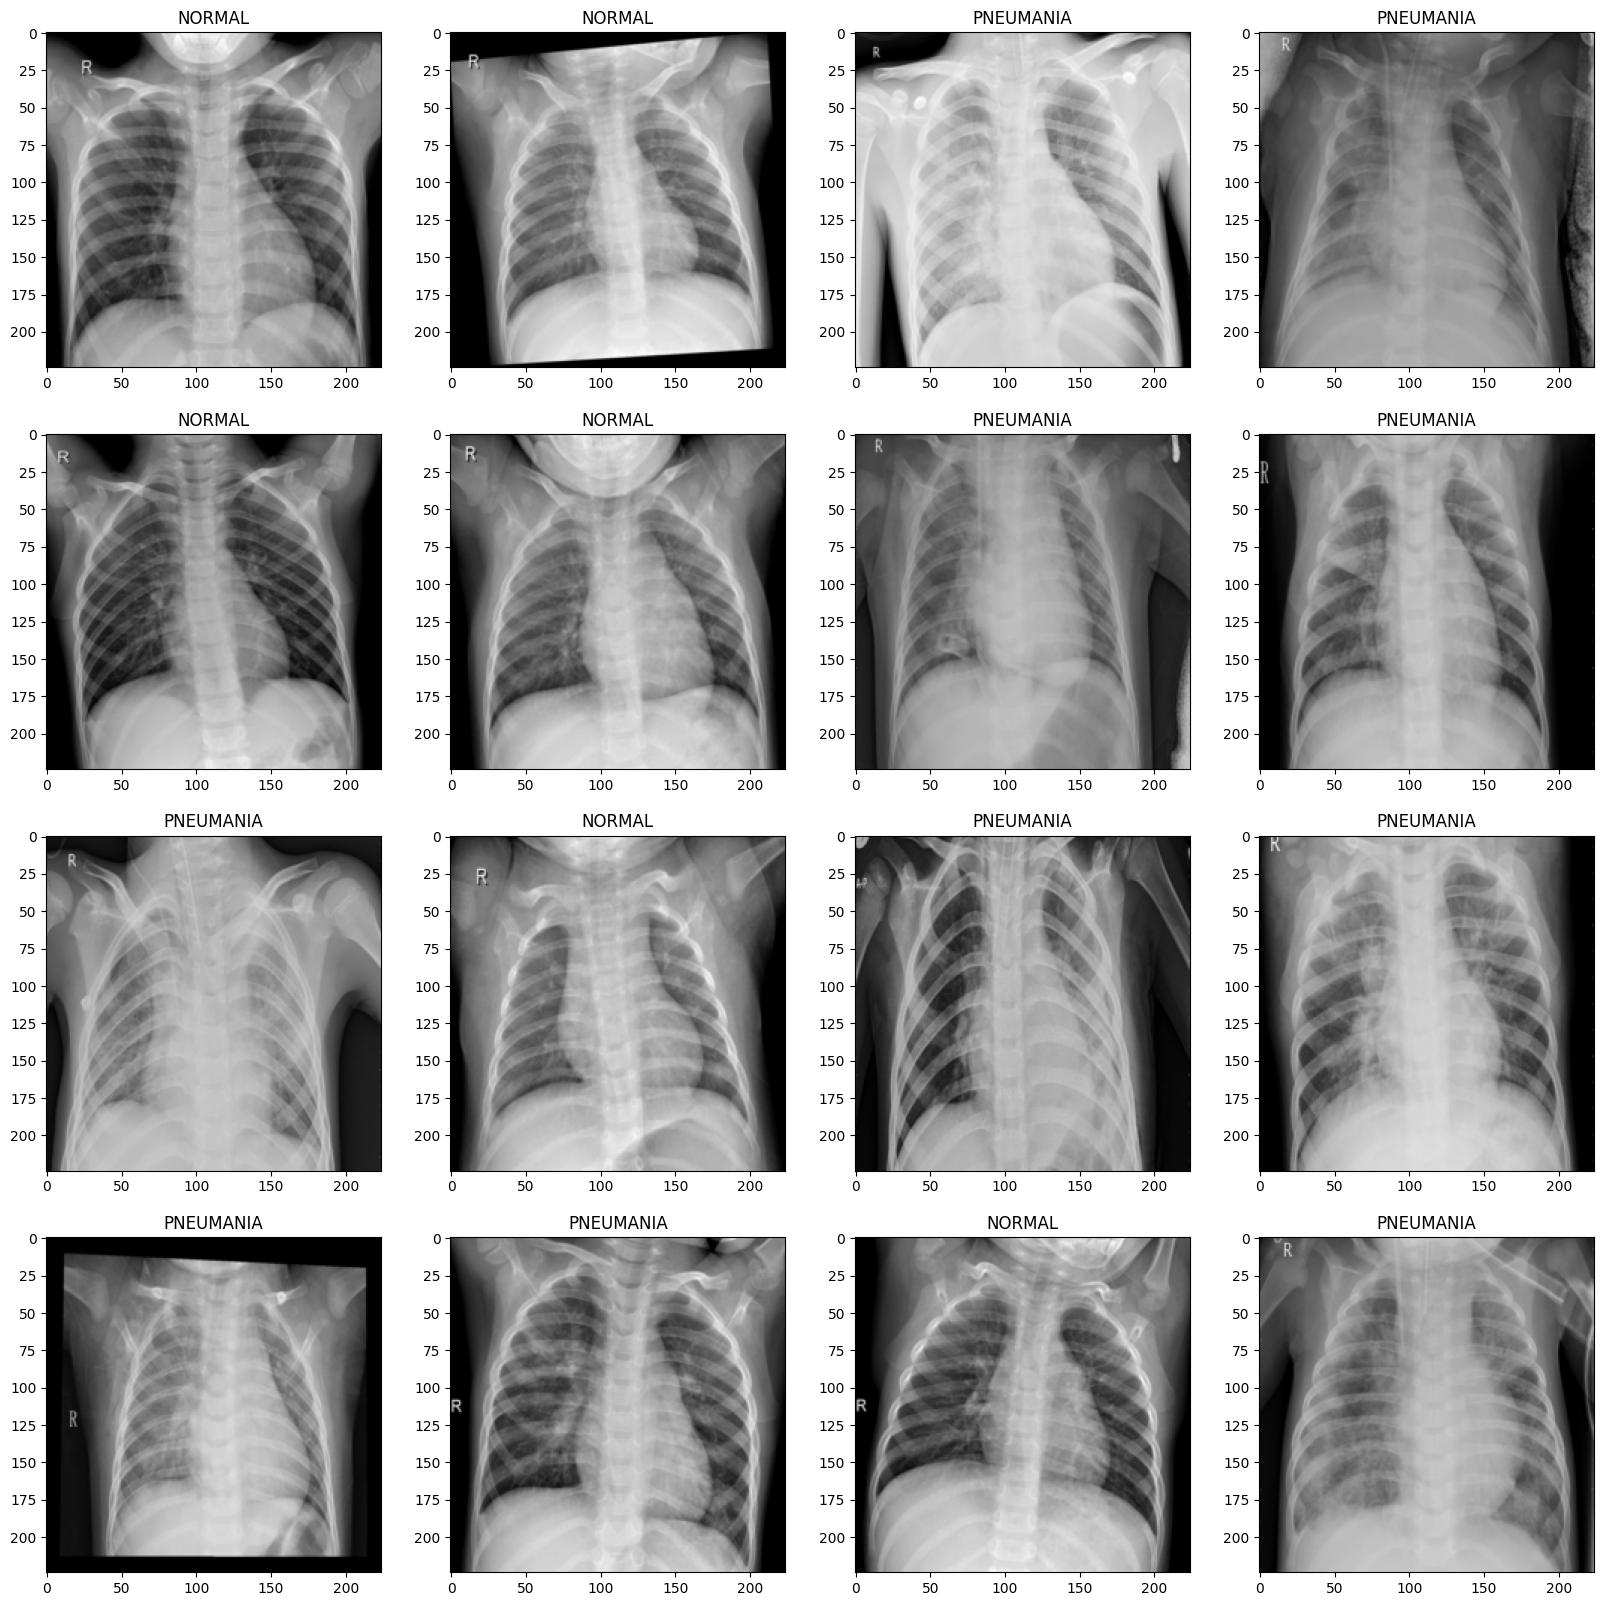

In [ ]:
from torchvision.utils import make_grid

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
sample = np.random.randint(0, len(train_loader.dataset), 16)
for i, index in enumerate(sample):
    img, target = train_loader.dataset[index]
    img = img.permute(1, 2, 0)

    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].set_title("{}".format(classes[target]))

## Model architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1)
        self.batch_norm_conv1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.batch_norm_conv2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.batch_norm_conv3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5, inplace=False)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 26 * 26, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv and Pool layers
        x = self.pool(self.batch_norm_conv1(F.relu(self.conv1(x))))
        x = self.pool(self.batch_norm_conv2(F.relu(self.conv2(x))))
        x = self.pool(self.batch_norm_conv3(F.relu(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout and batch normalization
        x = self.dropout(self.batch_norm1(F.relu(self.fc1(x))))
        x = self.dropout(self.batch_norm2(F.relu(self.fc2(x))))
        x = self.fc3(x)

        return x

## Train and Testing Validation Data

In [5]:
def train(model, n_epochs, train_loader, valid_loader, criterion, optimizer, scheduler=None, early_stop_count=0):
  avg_train_losses = []
  avg_valid_losses = []
  avg_valid_acc = []
  batch_train_losses = []

  # make regularization if accuracy will be decrease
  early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

  for epoch in range(1, n_epochs + 1):
    train_losses, valid_losses, valid_accs = [], [], []

    # Training
    model.train()
    for input_data, classes in train_loader:
      data = input_data.to(device)
      target = classes.long().to(device)

      optimizer.zero_grad()
      output = model(data)  # predicted
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    # Evaluating validation data
    model.eval()
    for input_data, classes in valid_loader:
      data = input_data.to(device)
      target = classes.long().to(device)

      output = model(data)
      loss = criterion(output, target)
      valid_losses.append(loss.item())

      _, pred = torch.max(output, 1)

      valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    valid_acc = np.average(valid_accs)

    if scheduler:
      scheduler.step()

    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    avg_valid_acc.append(valid_acc)
    batch_train_losses.extend(train_losses)

    epoch_len = len(str(n_epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                f'train_loss: {train_loss:.5f} ' +
                f'valid_loss: {valid_loss:.5f} ' +
                f'valid_acc: {valid_acc*100:2.2f} %')

    if scheduler:
      print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
    print(print_msg)

    if early_stop_count:
      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
        print("Early stopping")
        break

  if early_stop_count:
    model.load_state_dict(torch.load("net.pth"))

  return avg_valid_losses, avg_train_losses, model, batch_train_losses

## Vizualization and Testing data

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
precision_score, recall_score, f1_score
import seaborn as sns

def visualize_batch_loss(batch_train_losses):
    plt.figure(figsize=(15, 3))
    xx = np.arange(0, len(batch_train_losses), 1)
    y_train = np.array(batch_train_losses)
    plt.plot(xx, y_train)
    plt.legend(["Training Loss"], labelcolor="black")
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.title("Loss of validation and training set")
    plt.show()

def visualize_loss(avg_valid_losses, avg_train_losses):
    plt.figure()
    xx = np.arange(0, len(avg_valid_losses), 1)
    y_valid = np.array(avg_valid_losses)
    y_train = np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train, color='red')
    plt.legend(("Validation Loss", "Training Loss"), labelcolor="black")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss of validation and training set")
    plt.ylim(0, max(max(y_valid), max(y_train)) * 1.1)
    plt.show()

def print_accuracy(model, criterion, test_loader, classes):
    model.eval()
    y_gts = np.array([])
    y_preds = np.array([])
    test_losses = []

    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, pred = torch.max(outputs, 1)
        y_gts = np.hstack((y_gts, labels.cpu().numpy()))
        y_preds = np.hstack((y_preds, pred.cpu().numpy()))

    accuracy = np.sum(y_gts == y_preds) / y_preds.shape[0] * 100
    avg_test_loss = np.mean(test_losses)

    precision = precision_score(y_gts, y_preds, average='macro') * 100
    recall = recall_score(y_gts, y_preds, average='macro') * 100
    f1 = f1_score(y_gts, y_preds, average='macro') * 100

    plot_confusion_matrix(y_gts, y_preds, classes)

    print("Accuracy the NN is: {:2.2f} %".format(accuracy))
    print("Average test loss: {:2.4f}".format(avg_test_loss))
    print("Precision: {:2.2f} %".format(precision))
    print("Recall: {:2.2f} %".format(recall))
    print("F1 Score: {:2.2f} %".format(f1))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Settings and Experiments

In [7]:
import torch.optim as optim

model = Net(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 4

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4, 5], 0.25)
avg_valid_losses, avg_train_losses, model, batch_train_losses = train(model, n_epochs,
                                                                      train_loader, valid_loader,
                                                                      criterion=criterion,
                                                                      optimizer=optimizer,
                                                                      scheduler=None,
                                                                      early_stop_count=10)


[1/4] train_loss: 0.21253 valid_loss: 1.15839 valid_acc: 46.41 %
Validation loss decreased (inf --> 1.158385).  Saving model ...
[2/4] train_loss: 0.10248 valid_loss: 0.15482 valid_acc: 95.16 %
Validation loss decreased (1.158385 --> 0.154816).  Saving model ...
[3/4] train_loss: 0.10945 valid_loss: 0.16994 valid_acc: 93.91 %
EarlyStopping counter: 1 out of 10
[4/4] train_loss: 0.07522 valid_loss: 0.07472 valid_acc: 97.50 %
Validation loss decreased (0.154816 --> 0.074717).  Saving model ...


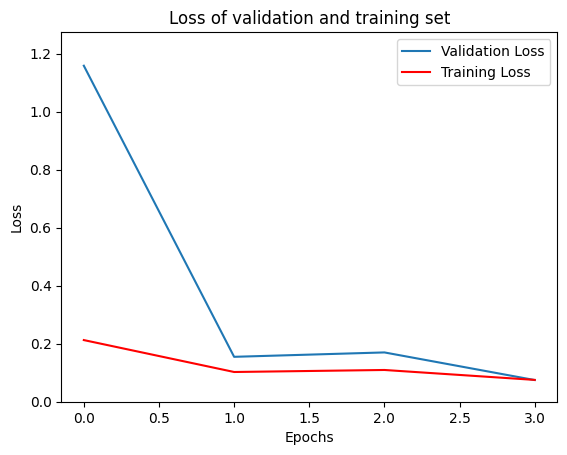

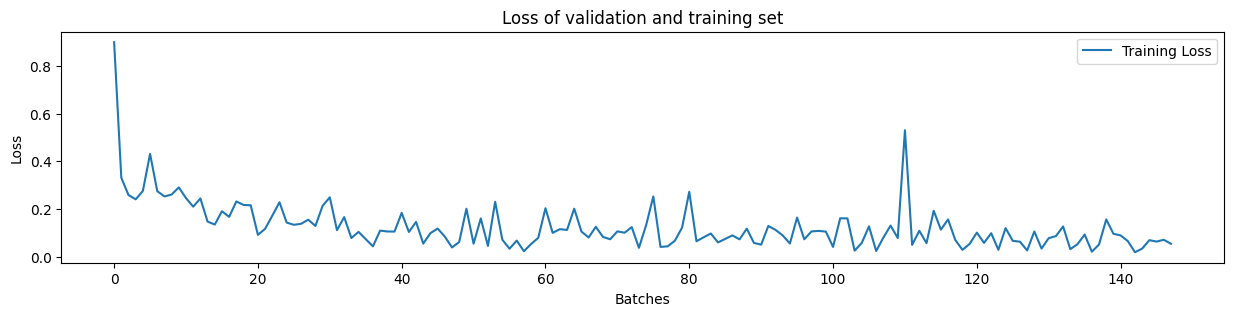

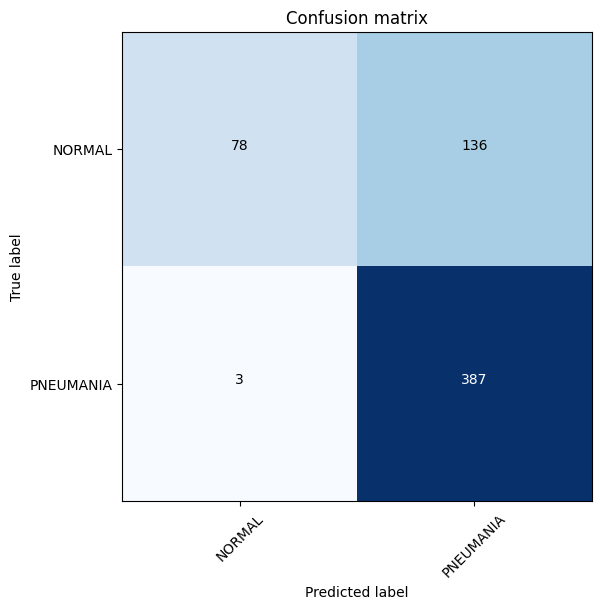

Accuracy the NN is: 76.99 %
Average test loss: 0.6722
Precision: 85.15 %
Recall: 67.84 %
F1 Score: 68.83 %


In [10]:
visualize_loss(avg_valid_losses, avg_train_losses)
visualize_batch_loss(batch_train_losses)
print_accuracy(model, criterion, test_loader, classes)